## NTSB Narrative Data Exploration

- Text pre-processing
- Corpus counts over time
- Topic modeling

In [69]:
import pandas as pd
import numpy as np
import os
import scipy as sp
import sklearn
import sys
from gensim.models import ldamodel
import gensim.corpora
from sklearn.preprocessing import normalize
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

%matplotlib inline

In [44]:
df = pd.DataFrame()

#Read in narrative json files from data directory, parse json file to columns, append to one dataframe
for file in os.listdir("data"):
    if file.startswith("NarrativeData_"):
        df = df.append(pd.read_json(os.path.join('data/', file), orient='split'))
        
print('The narrative json data contains {} columns and {} rows.'.format(df.shape[1], df.shape[0]))

In [45]:
df.head()

,EventId,narrative,probable_cause
0,20100412X54138,NTSB investigators used data provided by vario...,The pilot's failure to maintain directional co...
1,20001212X22328,NTSB investigators may have traveled in suppor...,A total loss of engine power for undetermined ...
2,20001211X11810,NTSB investigators may not have traveled in su...,THE STUDENT PILOT'S FAILURE TO MAINTAIN AIRCR...
3,20001207X04295,NTSB investigators may not have traveled in su...,the accidental discharge of a spear gun by the...
4,20030827X01411,NTSB investigators may not have traveled in su...,The failure of the exhaust valve on the number...


## Text Pre-Processing

- Stopwords
- Case conversion
- Porter Stemming
- Punctuation Removal

In [54]:
#Get list of english stopwords from the nltk package
from nltk.corpus import stopwords
stop = stopwords.words('english')

#Remove punctuation from stopwords list
stop= [re.sub('[^\w\s]','', word) for word in stop]

#Add custom stopwords based on context
stop = stop + ['ntsb', 'result', 'factor', 'may', 'contribute']
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', '

In [63]:
def clean_text(x, stopwords):
    
    """
    Performs text pre-processing on string: case converstion, punctuation removal, tokenization, porter stemming, and stopword removal.
    
    Parameters:
    
    x - Sstring to be processed
    stopwords - A list of strings to be used as stop words
    
    """
    
    x = re.sub(r'[^\w\s]','',x) #Remove punctuation
    x = x.lower().split() #Tokenize and lowercase text
    
    #Porter Stemming & stop word removal
    ps = PorterStemmer()
    x = [ps.stem(word) for word in x if word not in stopwords]

    #Return processed text
    return(x)

df['probable_cause_clean'] = df.apply(lambda x: clean_text(x.probable_cause, stopwords=stop), axis=1)
df['narrative_clean'] = df.apply(lambda x: clean_text(x.narrative, stopwords=stop), axis=1)

In [64]:
df.head()

,EventId,narrative,probable_cause,probable_cause_clean,narrative_clean
0,20100412X54138,NTSB investigators used data provided by vario...,The pilot's failure to maintain directional co...,"[pilot, failur, maintain, direct, control, air...","[investig, use, data, provid, variou, entiti, ..."
1,20001212X22328,NTSB investigators may have traveled in suppor...,A total loss of engine power for undetermined ...,"[total, loss, engin, power, undetermin, reason]","[investig, may, travel, support, investig, use..."
2,20001211X11810,NTSB investigators may not have traveled in su...,THE STUDENT PILOT'S FAILURE TO MAINTAIN AIRCR...,"[student, pilot, failur, maintain, aircraft, d...","[investig, may, travel, support, investig, use..."
3,20001207X04295,NTSB investigators may not have traveled in su...,the accidental discharge of a spear gun by the...,"[accident, discharg, spear, gun, observ]","[investig, may, travel, support, investig, use..."
4,20030827X01411,NTSB investigators may not have traveled in su...,The failure of the exhaust valve on the number...,"[failur, exhaust, valv, number, two, engin, cy...","[investig, may, travel, support, investig, use..."


## Corpus Frequency

What are the most common words in corpus?

Produce two plots: Top 20 tokens in probable_cause and narrative columns

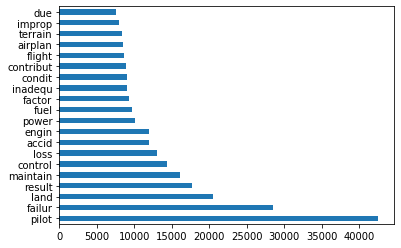

In [70]:
pd.Series([x for item in df.probable_cause_clean for x in item]).value_counts()[:20].plot(kind='barh')

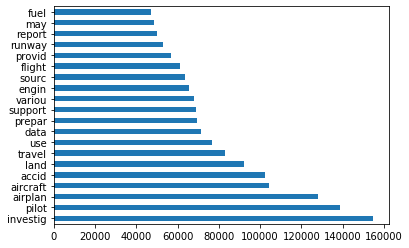

In [71]:
pd.Series([x for item in df.narrative_clean for x in item]).value_counts()[:20].plot(kind='barh')

## Corpus Frequency over Time

Do the common words in the corpus change over time?

In [83]:
# Merge to cleaned aviation data from NTSB.ipynb to get date data
ntsb  = pd.read_csv('data/aviation_data.csv')
merged = df.merge(ntsb, on='EventId')
merged.head()

,EventId,narrative,probable_cause,probable_cause_clean,narrative_clean,Unnamed: 0,AccidentNumber,AirCarrier,AircraftCategory,AircraftDamage,...,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured,WeatherCondition,year,City,State,fatalities,month
0,20100412X54138,NTSB investigators used data provided by vario...,The pilot's failure to maintain directional co...,"[pilot, failur, maintain, direct, control, air...","[investig, use, data, provid, variou, entiti, ...",9208,ERA10CA225,NaN,Airplane,Substantial,...,NaN,NaN,NaN,1.0,VMC,2010.0,Lakeland,FL,NaN,4.0
1,20001212X22328,NTSB investigators may have traveled in suppor...,A total loss of engine power for undetermined ...,"[total, loss, engin, power, undetermin, reason]","[investig, may, travel, support, investig, use...",27585,NYC01LA031,NaN,NaN,Substantial,...,0.0,1.0,1.0,0.0,VMC,2000.0,Middletown,NY,NaN,11.0
2,20001211X11810,NTSB investigators may not have traveled in su...,THE STUDENT PILOT'S FAILURE TO MAINTAIN AIRCR...,"[student, pilot, failur, maintain, aircraft, d...","[investig, may, travel, support, investig, use...",44995,CHI93LA097,NaN,NaN,Substantial,...,0.0,0.0,0.0,1.0,VMC,1993.0,Marshfield,WI,NaN,2.0
3,20030827X01411,NTSB investigators may not have traveled in su...,The failure of the exhaust valve on the number...,"[failur, exhaust, valv, number, two, engin, cy...","[investig, may, travel, support, investig, use...",21893,LAX03LA260,NaN,NaN,Substantial,...,NaN,NaN,NaN,1.0,VMC,2003.0,Saint Johns,AZ,NaN,8.0
4,20001212X16406,NTSB investigators may not have traveled in su...,THE PILOT'S INADEQUATE PREFLIGHT PLANNING IN ...,"[pilot, inadequ, preflight, plan, disregard, c...","[investig, may, travel, support, investig, use...",49828,ATL91LA055,NaN,NaN,Substantial,...,0.0,0.0,0.0,2.0,UNK,1991.0,Concord,NC,NaN,2.0


In [88]:
#Create dataframe that has one row per word in the probable cause data, with associated year
counts_df = merged[['EventId', 'probable_cause_clean', 'year']].explode('probable_cause_clean')
counts_df.head()

,EventId,probable_cause_clean,year
0,20100412X54138,pilot,2010.0
0,20100412X54138,failur,2010.0
0,20100412X54138,maintain,2010.0
0,20100412X54138,direct,2010.0
0,20100412X54138,control,2010.0


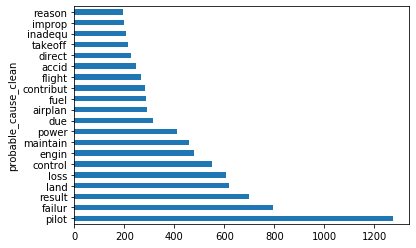

In [89]:
counts2010 = counts_df_explode[counts_df_explode['year'] == 2010.0]
counts2010.value_counts('probable_cause_clean')[:20].plot(kind='barh')

## Topic Modeling

In [73]:
df_lda = df[['probable_cause_clean']]
df_lda.head()

,probable_cause_clean
0,"[pilot, failur, maintain, direct, control, air..."
1,"[total, loss, engin, power, undetermin, reason]"
2,"[student, pilot, failur, maintain, aircraft, d..."
3,"[accident, discharg, spear, gun, observ]"
4,"[failur, exhaust, valv, number, two, engin, cy..."


In [78]:
training = [value[0] for value in df_lda.iloc[0:].values]
num_topics = 7

In [79]:
id2word = gensim.corpora.Dictionary(training)
corpus = [id2word.doc2bow(text) for text in training]
lda = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

In [80]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 40);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [81]:
lda_topics = get_lda_topics(lda, num_topics)
lda_topics.head(10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07
0,fuel,pilot,pilot,land,engin,flight,pilot
1,pilot,condit,failur,gear,loss,result,failur
2,engin,failur,land,failur,power,instructor,airplan
3,power,maintain,maintain,pilot,reason,inadequ,accid
4,result,factor,control,result,undetermin,control,lack
5,inadequ,accid,result,main,land,collis,aircraft
6,due,wind,direct,terrain,due,rotor,oper
7,loss,flight,airspe,right,forc,failur,contribut
8,exhaust,terrain,runway,left,failur,inflight,visual
9,preflight,weather,airplan,unsuit,terrain,student,factor
